Training model for spectrogram type: mel
Epoch 1/50
16/16 [==============================] - 37s 2s/step - loss: 0.7790 - accuracy: 0.5309 - val_loss: 0.8499 - val_accuracy: 0.4815
Epoch 2/50
16/16 [==============================] - 39s 2s/step - loss: 0.7617 - accuracy: 0.4897 - val_loss: 0.7539 - val_accuracy: 0.4815
Epoch 3/50
16/16 [==============================] - 39s 2s/step - loss: 0.6964 - accuracy: 0.5679 - val_loss: 0.7154 - val_accuracy: 0.5556
Epoch 4/50
16/16 [==============================] - 39s 2s/step - loss: 0.6464 - accuracy: 0.5802 - val_loss: 0.6975 - val_accuracy: 0.5926
Epoch 5/50
16/16 [==============================] - 40s 3s/step - loss: 0.5868 - accuracy: 0.6872 - val_loss: 0.7401 - val_accuracy: 0.4815
Epoch 6/50
16/16 [==============================] - 39s 2s/step - loss: 0.5217 - accuracy: 0.7737 - val_loss: 0.8466 - val_accuracy: 0.4074
Epoch 7/50
16/16 [==============================] - 41s 3s/step - loss: 0.4895 - accuracy: 0.7490 - val_loss: 0.8516 - 

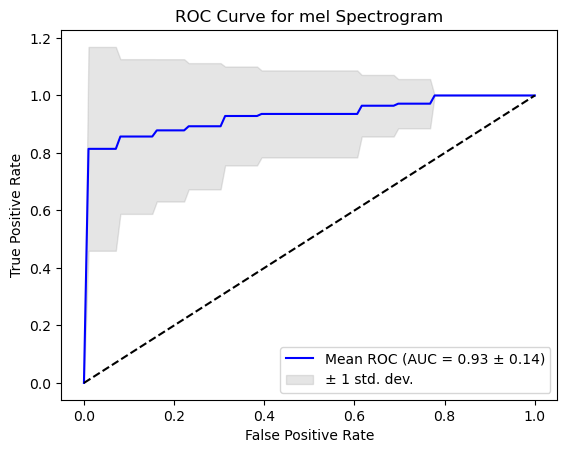


Mean and Std Dev of Performance Metrics for Spectrogram mel:
Fold                   5.500000
Accuracy              92.592593
F1 Score               0.919891
Precision              0.933843
Recall                 0.925926
Specificity            0.892308
Kappa                  0.849435
ROC AUC                0.931868
Training Time (s)    503.871212
Testing Time (s)       1.264929
dtype: float64
Fold                   3.027650
Accuracy              13.636248
F1 Score               0.152680
Precision              0.119390
Recall                 0.136362
Specificity            0.251753
Kappa                  0.279035
ROC AUC                0.148300
Training Time (s)    533.254617
Testing Time (s)       0.105893
dtype: float64


In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, LeakyReLU, Multiply, Add, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['mel']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels


# Define the PSFAN model function
def PSFAN(input, num_classes):
    conv1 = Conv2D(32, (3, 3), dilation_rate=1, activation=LeakyReLU(alpha=0.02))(input)
    x = Conv2D(32, (1, 1), padding='same')(conv1)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a = Activation('sigmoid')(x)
    attention = Multiply()([a, conv1])
    add = Add()([x, attention])
    M = MaxPooling2D(pool_size=(3, 3), padding='valid')(add)
    F = Flatten()(M)

    conv2 = Conv2D(32, (3, 3), dilation_rate=2, activation=LeakyReLU(alpha=0.02))(conv1)
    x = Conv2D(32, (1, 1), padding='same')(conv2)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a1 = Activation('sigmoid')(x)
    attention1 = Multiply()([a1, conv2])
    add1 = Add()([x, attention1])
    M1 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add1)
    F1 = Flatten()(M1)

    conv3 = Conv2D(64, (3, 3), dilation_rate=3, activation=LeakyReLU(alpha=0.02))(conv2)
    x = Conv2D(64, (1, 1), padding='same')(conv3)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a2 = Activation('sigmoid')(x)
    attention2 = Multiply()([a2, conv3])
    add2 = Add()([x, attention2])
    M2 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add2)
    F2 = Flatten()(M2)

    conv4 = Conv2D(64, (3, 3), dilation_rate=4, activation=LeakyReLU(alpha=0.02))(conv3)
    x = Conv2D(64, (1, 1), padding='same')(conv4)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a3 = Activation('sigmoid')(x)
    attention3 = Multiply()([a3, conv4])
    add3 = Add()([x, attention3])
    M3 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add3)
    F3 = Flatten()(M3)

    C = Concatenate()([F, F1, F2, F3])

    D2 = Dense(128, activation=LeakyReLU(alpha=0.02))(C)
    D2 = Dense(64, activation=LeakyReLU(alpha=0.02))(D2)

    OUT = Dense(num_classes, activation='softmax')(D2)
    model = Model(inputs=[input], outputs=OUT, name="PSFANModel")
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    input_layer = Input(shape=input_shape, name='input')
    model = PSFAN(input_layer, num_classes)

    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    fold_metrics = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train_index, test_index) in enumerate(kfold.split(x, y), 1):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)

        model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Record training time
        start_train = time.time()
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
        training_time = time.time() - start_train

        # Record testing time
        start_test = time.time()
        y_pred_prob = model.predict(X_test)
        testing_time = time.time() - start_test

        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)

        # Calculate metrics
        accuracy = np.mean(y_pred == y_true) * 100
        f1 = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        kappa = cohen_kappa_score(y_true, y_pred)

        # Specificity calculation
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)

        fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

        fold_metrics.append({
            "Fold": fold,
            "Accuracy": accuracy,
            "F1 Score": f1,
            "Precision": precision,
            "Recall": recall,
            "Specificity": specificity,
            "Kappa": kappa,
            "ROC AUC": roc_auc,
            "Training Time (s)": training_time,
            "Testing Time (s)": testing_time
        })

        print(f"Fold {fold} Results: Accuracy={accuracy:.2f}%, F1={f1:.2f}, Precision={precision:.2f}, Recall={recall:.2f}, Specificity={specificity:.2f}, Kappa={kappa:.2f}, ROC AUC={roc_auc:.2f}")
        
    # Plot ROC Curve with mean and std deviation
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)

    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2, label='± 1 std. dev.')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display mean and std dev of other metrics
    metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print(f"\nMean and Std Dev of Performance Metrics for Spectrogram {spectrogram}:")
    print(mean_metrics)
    print(std_metrics)


Training model for spectrogram type: mfcc
Epoch 1/50
16/16 [==============================] - 39s 2s/step - loss: 1.0527 - accuracy: 0.5432 - val_loss: 0.6907 - val_accuracy: 0.6296
Epoch 2/50
16/16 [==============================] - 37s 2s/step - loss: 0.7132 - accuracy: 0.5391 - val_loss: 0.7244 - val_accuracy: 0.4815
Epoch 3/50
16/16 [==============================] - 41s 3s/step - loss: 0.7032 - accuracy: 0.5350 - val_loss: 0.6945 - val_accuracy: 0.4815
Epoch 4/50
16/16 [==============================] - 41s 3s/step - loss: 0.6856 - accuracy: 0.5473 - val_loss: 0.7098 - val_accuracy: 0.4815
Epoch 5/50
16/16 [==============================] - 66s 4s/step - loss: 0.7146 - accuracy: 0.5021 - val_loss: 0.6974 - val_accuracy: 0.4815
Epoch 6/50
16/16 [==============================] - 66s 4s/step - loss: 0.7037 - accuracy: 0.5021 - val_loss: 0.6956 - val_accuracy: 0.5185
Fold 1 Results: Accuracy=62.96%, F1=0.61, Precision=0.66, Recall=0.63, Specificity=0.38, Kappa=0.25, ROC AUC=0.66
Epoc

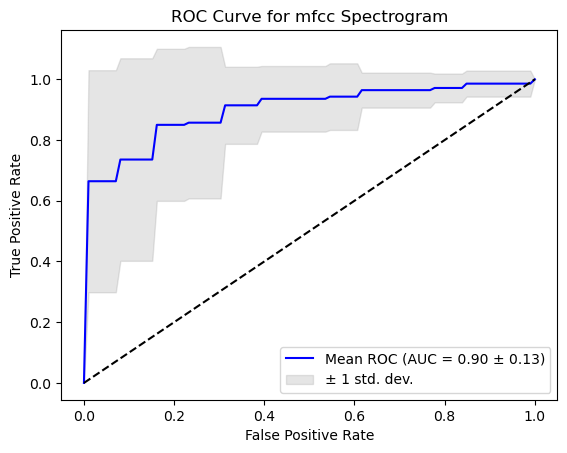


Mean and Std Dev of Performance Metrics for Spectrogram mfcc:
Fold                   5.500000
Accuracy              86.296296
F1 Score               0.858131
Precision              0.870214
Recall                 0.862963
Specificity            0.800000
Kappa                  0.722796
ROC AUC                0.900549
Training Time (s)    725.610540
Testing Time (s)       3.314340
dtype: float64
Fold                   3.027650
Accuracy              13.641836
F1 Score               0.145255
Precision              0.127434
Recall                 0.136418
Specificity            0.235563
Kappa                  0.278108
ROC AUC                0.135542
Training Time (s)    500.557254
Testing Time (s)       0.871815
dtype: float64


In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, LeakyReLU, Multiply, Add, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['mfcc']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels


# Define the PSFAN model function
def PSFAN(input, num_classes):
    conv1 = Conv2D(32, (3, 3), dilation_rate=1, activation=LeakyReLU(alpha=0.02))(input)
    x = Conv2D(32, (1, 1), padding='same')(conv1)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a = Activation('sigmoid')(x)
    attention = Multiply()([a, conv1])
    add = Add()([x, attention])
    M = MaxPooling2D(pool_size=(3, 3), padding='valid')(add)
    F = Flatten()(M)

    conv2 = Conv2D(32, (3, 3), dilation_rate=2, activation=LeakyReLU(alpha=0.02))(conv1)
    x = Conv2D(32, (1, 1), padding='same')(conv2)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a1 = Activation('sigmoid')(x)
    attention1 = Multiply()([a1, conv2])
    add1 = Add()([x, attention1])
    M1 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add1)
    F1 = Flatten()(M1)

    conv3 = Conv2D(64, (3, 3), dilation_rate=3, activation=LeakyReLU(alpha=0.02))(conv2)
    x = Conv2D(64, (1, 1), padding='same')(conv3)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a2 = Activation('sigmoid')(x)
    attention2 = Multiply()([a2, conv3])
    add2 = Add()([x, attention2])
    M2 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add2)
    F2 = Flatten()(M2)

    conv4 = Conv2D(64, (3, 3), dilation_rate=4, activation=LeakyReLU(alpha=0.02))(conv3)
    x = Conv2D(64, (1, 1), padding='same')(conv4)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a3 = Activation('sigmoid')(x)
    attention3 = Multiply()([a3, conv4])
    add3 = Add()([x, attention3])
    M3 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add3)
    F3 = Flatten()(M3)

    C = Concatenate()([F, F1, F2, F3])

    D2 = Dense(128, activation=LeakyReLU(alpha=0.02))(C)
    D2 = Dense(64, activation=LeakyReLU(alpha=0.02))(D2)

    OUT = Dense(num_classes, activation='softmax')(D2)
    model = Model(inputs=[input], outputs=OUT, name="PSFANModel")
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    input_layer = Input(shape=input_shape, name='input')
    model = PSFAN(input_layer, num_classes)

    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    fold_metrics = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train_index, test_index) in enumerate(kfold.split(x, y), 1):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)

        model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Record training time
        start_train = time.time()
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
        training_time = time.time() - start_train

        # Record testing time
        start_test = time.time()
        y_pred_prob = model.predict(X_test)
        testing_time = time.time() - start_test

        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)

        # Calculate metrics
        accuracy = np.mean(y_pred == y_true) * 100
        f1 = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        kappa = cohen_kappa_score(y_true, y_pred)

        # Specificity calculation
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)

        fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

        fold_metrics.append({
            "Fold": fold,
            "Accuracy": accuracy,
            "F1 Score": f1,
            "Precision": precision,
            "Recall": recall,
            "Specificity": specificity,
            "Kappa": kappa,
            "ROC AUC": roc_auc,
            "Training Time (s)": training_time,
            "Testing Time (s)": testing_time
        })

        print(f"Fold {fold} Results: Accuracy={accuracy:.2f}%, F1={f1:.2f}, Precision={precision:.2f}, Recall={recall:.2f}, Specificity={specificity:.2f}, Kappa={kappa:.2f}, ROC AUC={roc_auc:.2f}")
        
    # Plot ROC Curve with mean and std deviation
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)

    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2, label='± 1 std. dev.')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display mean and std dev of other metrics
    metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print(f"\nMean and Std Dev of Performance Metrics for Spectrogram {spectrogram}:")
    print(mean_metrics)
    print(std_metrics)


Training model for spectrogram type: chroma
Epoch 1/50
14/14 [==============================] - 33s 2s/step - loss: 0.9823 - accuracy: 0.4955 - val_loss: 0.7100 - val_accuracy: 0.6400
Epoch 2/50
14/14 [==============================] - 35s 2s/step - loss: 0.6106 - accuracy: 0.6682 - val_loss: 0.6986 - val_accuracy: 0.5600
Epoch 3/50
14/14 [==============================] - 32s 2s/step - loss: 0.5226 - accuracy: 0.7500 - val_loss: 0.6385 - val_accuracy: 0.7200
Epoch 4/50
14/14 [==============================] - 32s 2s/step - loss: 0.4335 - accuracy: 0.8227 - val_loss: 0.7279 - val_accuracy: 0.6000
Epoch 5/50
14/14 [==============================] - 33s 2s/step - loss: 0.3386 - accuracy: 0.8727 - val_loss: 0.7594 - val_accuracy: 0.5600
Epoch 6/50
14/14 [==============================] - 34s 2s/step - loss: 0.2395 - accuracy: 0.9273 - val_loss: 0.8232 - val_accuracy: 0.5600
Epoch 7/50
14/14 [==============================] - 37s 3s/step - loss: 0.1369 - accuracy: 0.9773 - val_loss: 0.8263

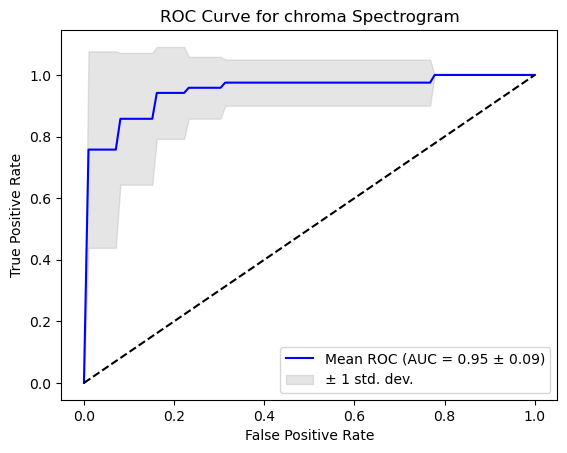


Mean and Std Dev of Performance Metrics for Spectrogram chroma:
Fold                   5.500000
Accuracy              91.566667
F1 Score               0.915239
Precision              0.922579
Recall                 0.915667
Specificity            0.884615
Kappa                  0.831864
ROC AUC                0.951166
Training Time (s)    608.953494
Testing Time (s)       1.243450
dtype: float64
Fold                   3.027650
Accuracy               9.130129
F1 Score               0.091644
Precision              0.086836
Recall                 0.091301
Specificity            0.126917
Kappa                  0.181965
ROC AUC                0.090160
Training Time (s)    675.671148
Testing Time (s)       0.080326
dtype: float64


In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, LeakyReLU, Multiply, Add, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['chroma']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels


# Define the PSFAN model function
def PSFAN(input, num_classes):
    conv1 = Conv2D(32, (3, 3), dilation_rate=1, activation=LeakyReLU(alpha=0.02))(input)
    x = Conv2D(32, (1, 1), padding='same')(conv1)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a = Activation('sigmoid')(x)
    attention = Multiply()([a, conv1])
    add = Add()([x, attention])
    M = MaxPooling2D(pool_size=(3, 3), padding='valid')(add)
    F = Flatten()(M)

    conv2 = Conv2D(32, (3, 3), dilation_rate=2, activation=LeakyReLU(alpha=0.02))(conv1)
    x = Conv2D(32, (1, 1), padding='same')(conv2)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a1 = Activation('sigmoid')(x)
    attention1 = Multiply()([a1, conv2])
    add1 = Add()([x, attention1])
    M1 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add1)
    F1 = Flatten()(M1)

    conv3 = Conv2D(64, (3, 3), dilation_rate=3, activation=LeakyReLU(alpha=0.02))(conv2)
    x = Conv2D(64, (1, 1), padding='same')(conv3)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a2 = Activation('sigmoid')(x)
    attention2 = Multiply()([a2, conv3])
    add2 = Add()([x, attention2])
    M2 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add2)
    F2 = Flatten()(M2)

    conv4 = Conv2D(64, (3, 3), dilation_rate=4, activation=LeakyReLU(alpha=0.02))(conv3)
    x = Conv2D(64, (1, 1), padding='same')(conv4)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a3 = Activation('sigmoid')(x)
    attention3 = Multiply()([a3, conv4])
    add3 = Add()([x, attention3])
    M3 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add3)
    F3 = Flatten()(M3)

    C = Concatenate()([F, F1, F2, F3])

    D2 = Dense(128, activation=LeakyReLU(alpha=0.02))(C)
    D2 = Dense(64, activation=LeakyReLU(alpha=0.02))(D2)

    OUT = Dense(num_classes, activation='softmax')(D2)
    model = Model(inputs=[input], outputs=OUT, name="PSFANModel")
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    input_layer = Input(shape=input_shape, name='input')
    model = PSFAN(input_layer, num_classes)

    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    fold_metrics = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train_index, test_index) in enumerate(kfold.split(x, y), 1):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)

        model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Record training time
        start_train = time.time()
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
        training_time = time.time() - start_train

        # Record testing time
        start_test = time.time()
        y_pred_prob = model.predict(X_test)
        testing_time = time.time() - start_test

        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)

        # Calculate metrics
        accuracy = np.mean(y_pred == y_true) * 100
        f1 = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        kappa = cohen_kappa_score(y_true, y_pred)

        # Specificity calculation
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)

        fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

        fold_metrics.append({
            "Fold": fold,
            "Accuracy": accuracy,
            "F1 Score": f1,
            "Precision": precision,
            "Recall": recall,
            "Specificity": specificity,
            "Kappa": kappa,
            "ROC AUC": roc_auc,
            "Training Time (s)": training_time,
            "Testing Time (s)": testing_time
        })

        print(f"Fold {fold} Results: Accuracy={accuracy:.2f}%, F1={f1:.2f}, Precision={precision:.2f}, Recall={recall:.2f}, Specificity={specificity:.2f}, Kappa={kappa:.2f}, ROC AUC={roc_auc:.2f}")
        
    # Plot ROC Curve with mean and std deviation
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)

    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2, label='± 1 std. dev.')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display mean and std dev of other metrics
    metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print(f"\nMean and Std Dev of Performance Metrics for Spectrogram {spectrogram}:")
    print(mean_metrics)
    print(std_metrics)


Training model for spectrogram type: stft
Epoch 1/50
14/14 [==============================] - 36s 3s/step - loss: 0.9795 - accuracy: 0.5227 - val_loss: 0.7876 - val_accuracy: 0.4800
Epoch 2/50
14/14 [==============================] - 35s 3s/step - loss: 0.7452 - accuracy: 0.5545 - val_loss: 0.7958 - val_accuracy: 0.5200
Epoch 3/50
14/14 [==============================] - 35s 3s/step - loss: 0.6757 - accuracy: 0.6091 - val_loss: 0.6698 - val_accuracy: 0.6800
Epoch 4/50
14/14 [==============================] - 35s 2s/step - loss: 0.5644 - accuracy: 0.7318 - val_loss: 0.6534 - val_accuracy: 0.7200
Epoch 5/50
14/14 [==============================] - 35s 2s/step - loss: 0.5013 - accuracy: 0.7455 - val_loss: 0.6276 - val_accuracy: 0.6000
Epoch 6/50
14/14 [==============================] - 35s 2s/step - loss: 0.4503 - accuracy: 0.8045 - val_loss: 0.6135 - val_accuracy: 0.6400
Epoch 7/50
14/14 [==============================] - 24715s 1765s/step - loss: 0.4012 - accuracy: 0.8318 - val_loss: 0.

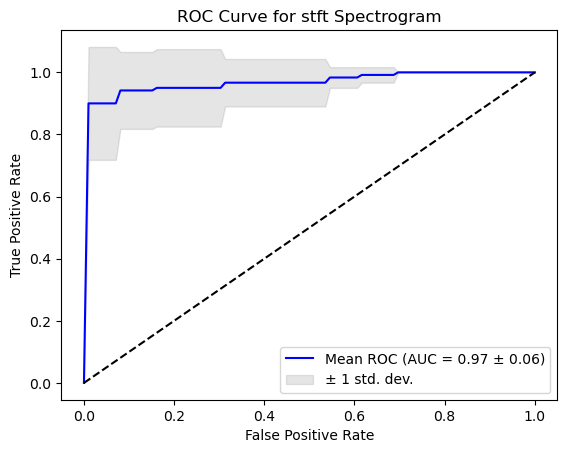


Mean and Std Dev of Performance Metrics for Spectrogram stft:
Fold                    5.500000
Accuracy               93.200000
F1 Score                0.931028
Precision               0.935667
Recall                  0.932000
Specificity             0.907692
Kappa                   0.865178
ROC AUC                 0.970513
Training Time (s)    7102.878547
Testing Time (s)        1.218989
dtype: float64
Fold                     3.027650
Accuracy                13.339998
F1 Score                 0.135769
Precision                0.126648
Recall                   0.133400
Specificity              0.184188
Kappa                    0.264004
ROC AUC                  0.066219
Training Time (s)    20939.989380
Testing Time (s)         0.101200
dtype: float64


In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, LeakyReLU, Multiply, Add, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['stft']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels


# Define the PSFAN model function
def PSFAN(input, num_classes):
    conv1 = Conv2D(32, (3, 3), dilation_rate=1, activation=LeakyReLU(alpha=0.02))(input)
    x = Conv2D(32, (1, 1), padding='same')(conv1)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a = Activation('sigmoid')(x)
    attention = Multiply()([a, conv1])
    add = Add()([x, attention])
    M = MaxPooling2D(pool_size=(3, 3), padding='valid')(add)
    F = Flatten()(M)

    conv2 = Conv2D(32, (3, 3), dilation_rate=2, activation=LeakyReLU(alpha=0.02))(conv1)
    x = Conv2D(32, (1, 1), padding='same')(conv2)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a1 = Activation('sigmoid')(x)
    attention1 = Multiply()([a1, conv2])
    add1 = Add()([x, attention1])
    M1 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add1)
    F1 = Flatten()(M1)

    conv3 = Conv2D(64, (3, 3), dilation_rate=3, activation=LeakyReLU(alpha=0.02))(conv2)
    x = Conv2D(64, (1, 1), padding='same')(conv3)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a2 = Activation('sigmoid')(x)
    attention2 = Multiply()([a2, conv3])
    add2 = Add()([x, attention2])
    M2 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add2)
    F2 = Flatten()(M2)

    conv4 = Conv2D(64, (3, 3), dilation_rate=4, activation=LeakyReLU(alpha=0.02))(conv3)
    x = Conv2D(64, (1, 1), padding='same')(conv4)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a3 = Activation('sigmoid')(x)
    attention3 = Multiply()([a3, conv4])
    add3 = Add()([x, attention3])
    M3 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add3)
    F3 = Flatten()(M3)

    C = Concatenate()([F, F1, F2, F3])

    D2 = Dense(128, activation=LeakyReLU(alpha=0.02))(C)
    D2 = Dense(64, activation=LeakyReLU(alpha=0.02))(D2)

    OUT = Dense(num_classes, activation='softmax')(D2)
    model = Model(inputs=[input], outputs=OUT, name="PSFANModel")
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    input_layer = Input(shape=input_shape, name='input')
    model = PSFAN(input_layer, num_classes)

    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    fold_metrics = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train_index, test_index) in enumerate(kfold.split(x, y), 1):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)

        model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Record training time
        start_train = time.time()
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
        training_time = time.time() - start_train

        # Record testing time
        start_test = time.time()
        y_pred_prob = model.predict(X_test)
        testing_time = time.time() - start_test

        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)

        # Calculate metrics
        accuracy = np.mean(y_pred == y_true) * 100
        f1 = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        kappa = cohen_kappa_score(y_true, y_pred)

        # Specificity calculation
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)

        fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

        fold_metrics.append({
            "Fold": fold,
            "Accuracy": accuracy,
            "F1 Score": f1,
            "Precision": precision,
            "Recall": recall,
            "Specificity": specificity,
            "Kappa": kappa,
            "ROC AUC": roc_auc,
            "Training Time (s)": training_time,
            "Testing Time (s)": testing_time
        })

        print(f"Fold {fold} Results: Accuracy={accuracy:.2f}%, F1={f1:.2f}, Precision={precision:.2f}, Recall={recall:.2f}, Specificity={specificity:.2f}, Kappa={kappa:.2f}, ROC AUC={roc_auc:.2f}")
        
    # Plot ROC Curve with mean and std deviation
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)

    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2, label='± 1 std. dev.')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display mean and std dev of other metrics
    metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print(f"\nMean and Std Dev of Performance Metrics for Spectrogram {spectrogram}:")
    print(mean_metrics)
    print(std_metrics)


Training model for spectrogram type: cqt
Epoch 1/50
14/14 [==============================] - 34s 2s/step - loss: 0.9756 - accuracy: 0.4636 - val_loss: 0.7313 - val_accuracy: 0.5600
Epoch 2/50
14/14 [==============================] - 33s 2s/step - loss: 0.6896 - accuracy: 0.5636 - val_loss: 0.6832 - val_accuracy: 0.5200
Epoch 3/50
14/14 [==============================] - 33s 2s/step - loss: 0.6275 - accuracy: 0.6364 - val_loss: 0.6363 - val_accuracy: 0.6800
Epoch 4/50
14/14 [==============================] - 33s 2s/step - loss: 0.5856 - accuracy: 0.6909 - val_loss: 0.6578 - val_accuracy: 0.5200
Epoch 5/50
14/14 [==============================] - 34s 2s/step - loss: 0.5510 - accuracy: 0.7091 - val_loss: 0.6137 - val_accuracy: 0.5600
Epoch 6/50
14/14 [==============================] - 36s 3s/step - loss: 0.5010 - accuracy: 0.8136 - val_loss: 0.5995 - val_accuracy: 0.6400
Epoch 7/50
14/14 [==============================] - 35s 2s/step - loss: 0.4452 - accuracy: 0.8318 - val_loss: 0.5469 - 

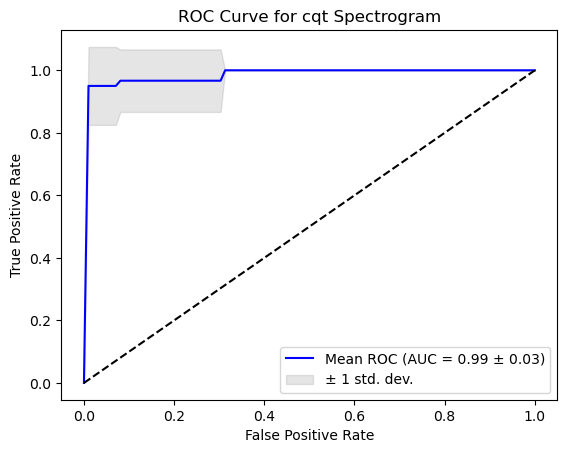


Mean and Std Dev of Performance Metrics for Spectrogram cqt:
Fold                   5.500000
Accuracy              97.200000
F1 Score               0.971580
Precision              0.974810
Recall                 0.972000
Specificity            0.976923
Kappa                  0.943623
ROC AUC                0.988462
Training Time (s)    403.323351
Testing Time (s)       1.207047
dtype: float64
Fold                   3.027650
Accuracy               6.545567
F1 Score               0.066630
Precision              0.059598
Recall                 0.065456
Specificity            0.051919
Kappa                  0.132169
ROC AUC                0.034295
Training Time (s)    279.912721
Testing Time (s)       0.112816
dtype: float64


In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, LeakyReLU, Multiply, Add, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['cqt']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels


# Define the PSFAN model function
def PSFAN(input, num_classes):
    conv1 = Conv2D(32, (3, 3), dilation_rate=1, activation=LeakyReLU(alpha=0.02))(input)
    x = Conv2D(32, (1, 1), padding='same')(conv1)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a = Activation('sigmoid')(x)
    attention = Multiply()([a, conv1])
    add = Add()([x, attention])
    M = MaxPooling2D(pool_size=(3, 3), padding='valid')(add)
    F = Flatten()(M)

    conv2 = Conv2D(32, (3, 3), dilation_rate=2, activation=LeakyReLU(alpha=0.02))(conv1)
    x = Conv2D(32, (1, 1), padding='same')(conv2)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a1 = Activation('sigmoid')(x)
    attention1 = Multiply()([a1, conv2])
    add1 = Add()([x, attention1])
    M1 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add1)
    F1 = Flatten()(M1)

    conv3 = Conv2D(64, (3, 3), dilation_rate=3, activation=LeakyReLU(alpha=0.02))(conv2)
    x = Conv2D(64, (1, 1), padding='same')(conv3)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a2 = Activation('sigmoid')(x)
    attention2 = Multiply()([a2, conv3])
    add2 = Add()([x, attention2])
    M2 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add2)
    F2 = Flatten()(M2)

    conv4 = Conv2D(64, (3, 3), dilation_rate=4, activation=LeakyReLU(alpha=0.02))(conv3)
    x = Conv2D(64, (1, 1), padding='same')(conv4)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a3 = Activation('sigmoid')(x)
    attention3 = Multiply()([a3, conv4])
    add3 = Add()([x, attention3])
    M3 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add3)
    F3 = Flatten()(M3)

    C = Concatenate()([F, F1, F2, F3])

    D2 = Dense(128, activation=LeakyReLU(alpha=0.02))(C)
    D2 = Dense(64, activation=LeakyReLU(alpha=0.02))(D2)

    OUT = Dense(num_classes, activation='softmax')(D2)
    model = Model(inputs=[input], outputs=OUT, name="PSFANModel")
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    input_layer = Input(shape=input_shape, name='input')
    model = PSFAN(input_layer, num_classes)

    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    fold_metrics = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train_index, test_index) in enumerate(kfold.split(x, y), 1):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)

        model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Record training time
        start_train = time.time()
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
        training_time = time.time() - start_train

        # Record testing time
        start_test = time.time()
        y_pred_prob = model.predict(X_test)
        testing_time = time.time() - start_test

        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)

        # Calculate metrics
        accuracy = np.mean(y_pred == y_true) * 100
        f1 = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        kappa = cohen_kappa_score(y_true, y_pred)

        # Specificity calculation
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)

        fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

        fold_metrics.append({
            "Fold": fold,
            "Accuracy": accuracy,
            "F1 Score": f1,
            "Precision": precision,
            "Recall": recall,
            "Specificity": specificity,
            "Kappa": kappa,
            "ROC AUC": roc_auc,
            "Training Time (s)": training_time,
            "Testing Time (s)": testing_time
        })

        print(f"Fold {fold} Results: Accuracy={accuracy:.2f}%, F1={f1:.2f}, Precision={precision:.2f}, Recall={recall:.2f}, Specificity={specificity:.2f}, Kappa={kappa:.2f}, ROC AUC={roc_auc:.2f}")
        
    # Plot ROC Curve with mean and std deviation
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)

    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2, label='± 1 std. dev.')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display mean and std dev of other metrics
    metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print(f"\nMean and Std Dev of Performance Metrics for Spectrogram {spectrogram}:")
    print(mean_metrics)
    print(std_metrics)
